<a href="https://colab.research.google.com/github/hectormelo/Machine-Learning-Techniques/blob/main/Taller_5/Taller_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://raw.githubusercontent.com/hectormelo/Machine-Learning-Techniques/main/Banner.png" ><br>
# Machine Learning Techniques - MISIS4219

Primer semestre - 2024

## Taller 5

Este taller consta de un punto, el cual se desarrollara implementando todo lo que hemos visto en esta y las anteriores clases.

**Integrante 1:** Jose Manuel Moreno - 201011998

**Integrante 2:** William Ravelo - 201532093


**NOTA:** El archivo .pynb entregado debe tener todas las celdas ejecutadas, con los resultados visibles. El nombre del archivo debe ser NombreApellido1_NombreApellido2_TallerS10.ipynb

**Dataset** : Enlace para descargar el dataset: https://drive.google.com/file/d/1C4zZPQcRY52UzgM8z-gzm4dVtSpSaDmw/view?usp=sharing

**Objetivo**: Contruir modelos de deep learning que ayude a clasificar una imagen en alguna de esas 8 clases del dataset (cada folder en el dataset es una categoría). Va a comparar el performance entre una arquitectura densa y Convnets.


## Helpers

In [250]:
import os
import pandas as pd
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, MaxPooling2D, Conv2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.image as img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import shuffle

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer

In [251]:
IMG_SIZE =244

def preprocessig_data(data):
    X = []
    for img_path in data:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)#Pasamos la imagen a escala de grises
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0 # normalizamos los pixeles de la imagen

        X.append(img)

    X = np.array(X)
    X = X.reshape((-1, IMG_SIZE, IMG_SIZE, 1)) #Hacemos un reshape de las imagenes

    return X

## Carga de datos

In [252]:
images_path = './natural_images'

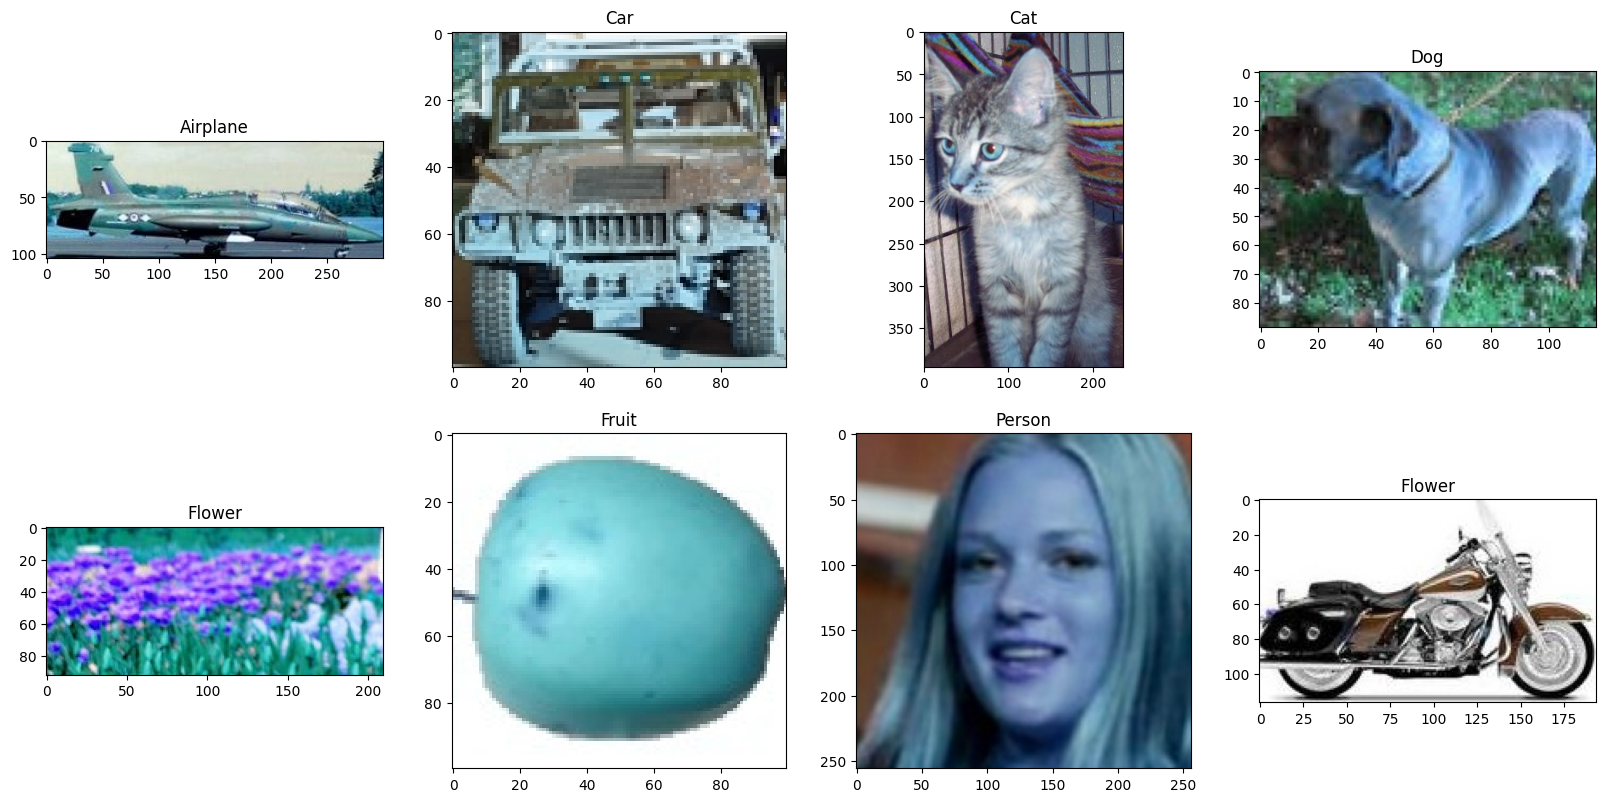

In [253]:
# Ejemplo imagenes
plt.figure(figsize=(20,20))

plt.subplot(4, 4, 1)
plt.title('Airplane')
plt.imshow(cv2.imread(f'{images_path}/airplane/airplane_0000.jpg'))

plt.subplot(4, 4, 2)
plt.title('Car')
plt.imshow(cv2.imread(f'{images_path}/car/car_0000.jpg'))

plt.subplot(4, 4, 3)
plt.title('Cat')
plt.imshow(cv2.imread(f'{images_path}/cat/cat_0000.jpg'))

plt.subplot(4, 4, 4)
plt.title('Dog')
plt.imshow(cv2.imread(f'{images_path}/dog/dog_0000.jpg'))

plt.subplot(4, 4, 5)
plt.title('Flower')
plt.imshow(cv2.imread(f'{images_path}/flower/flower_0000.jpg'))

plt.subplot(4, 4, 6)
plt.title('Fruit')
plt.imshow(cv2.imread(f'{images_path}/fruit/fruit_0000.jpg'))

plt.subplot(4, 4, 7)
plt.title('Person')
plt.imshow(cv2.imread(f'{images_path}/person/person_0000.jpg'))

plt.subplot(4, 4, 8)
plt.title('Flower')
plt.imshow(cv2.imread(f'{images_path}/motorbike/motorbike_0000.jpg'))

plt.show()

In [254]:
filepaths=[]
labels=[]
classlist=os.listdir(images_path)
for klass in classlist:
    classpath=os.path.join(images_path,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)

Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print('distribucion de los datos'.center(60,'-'))
print (df['labels'].value_counts())

                           filepaths labels
0  ./natural_images/cat/cat_0258.jpg    cat
1  ./natural_images/cat/cat_0516.jpg    cat
2  ./natural_images/cat/cat_0270.jpg    cat
3  ./natural_images/cat/cat_0264.jpg    cat
4  ./natural_images/cat/cat_0502.jpg    cat
-----------------distribucion de los datos------------------
labels
fruit        1000
person        986
car           968
cat           885
flower        843
motorbike     788
airplane      727
dog           702
Name: count, dtype: int64


In [255]:
# Manejo desbalance de los datos
fruit_df = shuffle(df.loc[df['labels'] == 'fruit']).head(702).reset_index(drop=True)
person_df = shuffle(df.loc[df['labels'] == 'person']).head(702).reset_index(drop=True)
car_df = shuffle(df.loc[df['labels'] == 'car']).head(702).reset_index(drop=True)
cat_df = shuffle(df.loc[df['labels'] == 'cat']).head(702).reset_index(drop=True)
flower_df = shuffle(df.loc[df['labels'] == 'flower']).head(702).reset_index(drop=True)
motorbike_df = shuffle(df.loc[df['labels'] == 'motorbike']).head(702).reset_index(drop=True)
airplane_df = shuffle(df.loc[df['labels'] == 'airplane']).head(702).reset_index(drop=True)
dog_df = shuffle(df.loc[df['labels'] == 'dog']).head(702).reset_index(drop=True)

print(fruit_df.shape, person_df.shape, car_df.shape, cat_df.shape, flower_df.shape, motorbike_df.shape, airplane_df.shape, dog_df.shape)

(702, 2) (702, 2) (702, 2) (702, 2) (702, 2) (702, 2) (702, 2) (702, 2)


In [256]:
balanced_df = pd.concat([fruit_df, person_df, car_df, cat_df, flower_df, motorbike_df, airplane_df, dog_df], ignore_index=True)
balanced_df = shuffle(balanced_df).reset_index(drop = True)
balanced_df.head()

filepaths    labels
0            ./natural_images/car/car_0275.jpg       car
1            ./natural_images/dog/dog_0162.jpg       dog
2  ./natural_images/airplane/airplane_0595.jpg  airplane
3            ./natural_images/cat/cat_0805.jpg       cat
4  ./natural_images/airplane/airplane_0047.jpg  airplane

In [257]:
X_train, X_test, y_train, y_test = train_test_split(balanced_df['filepaths'], balanced_df['labels'], test_size=0.30, random_state=33)

X_test, X_val, y_test, y_val= train_test_split(X_test, y_test, train_size=0.5, random_state=34)

## Preprocesamiento de los datos

In [258]:
X_train = preprocessig_data(X_train)
X_val = preprocessig_data(X_val)

In [259]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

y_train = to_categorical(y_train, num_classes=8)
y_val = to_categorical(y_val, num_classes=8)

## Punto 1: Clasificación de imágenes con arquitectura densa

Requerimientos básicos:
- Divida el dataset en particiones de entrenamiento, validación y testing.
- Proponga una arquitectura de red neuronal densa con al menos 3 capas.
- Entrene el modelo y genere las curvas de loss vs epoch para los sets de entrenamiento y validación.
- Hacer deploy del modelo (realizar prediccion sobre una imagen dada fuera del dataset).
- Evalue el modelo sobre testing y obtenga el reporte de precision, recall  f1-score. Puede utilizar el macro o micro average.

### Arquitectura y entrenamiento del modelo

In [260]:
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)

In [261]:
model_base = tf.keras.models.Sequential([
  Flatten(input_shape =(IMG_SIZE,IMG_SIZE,1)),

  Dense(250, activation='relu'),
  Dropout(0.15),

  Dense(100, activation='relu'),
  Dropout(0.15),

  Dense(8, activation= 'softmax')
])

/Users/willy/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [262]:
model_base.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [263]:
model_base.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_10 (Flatten)            │ (None, 59536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 250)            │    14,884,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 100)            │        25,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 8)              │           808 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,910,158 (56.88 MB)

 Trainable params: 14,910,158 (56.88 MB)

 Non-trainable params: 0 (0.00 B)

In [264]:
history_base = model_base.fit(X_train, y_train, validation_data= (X_val, y_val), batch_size=128, epochs = 200, callbacks=[early])

Epoch 1/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.1778 - loss: 14.9027 - val_accuracy: 0.4591 - val_loss: 1.5745
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3766 - loss: 1.7350 - val_accuracy: 0.5409 - val_loss: 1.3094
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4611 - loss: 1.4690 - val_accuracy: 0.5718 - val_loss: 1.2190
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5296 - loss: 1.3248 - val_accuracy: 0.6263 - val_loss: 1.1294
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5814 - loss: 1.2113 - val_accuracy: 0.6062 - val_loss: 1.0616
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5581 - loss: 1.2190 - val_accuracy: 0.5730 - val_loss: 1.1617
Epoch 7/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5274 - loss: 1.2862 - val_accuracy: 0.6382 - val_loss: 0.9990
Epoch 8/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5693 - loss: 1.1703 - val_accuracy: 0

### Grafica loss vs epoch

<Axes: xlabel='epochs', ylabel='accuracy'>

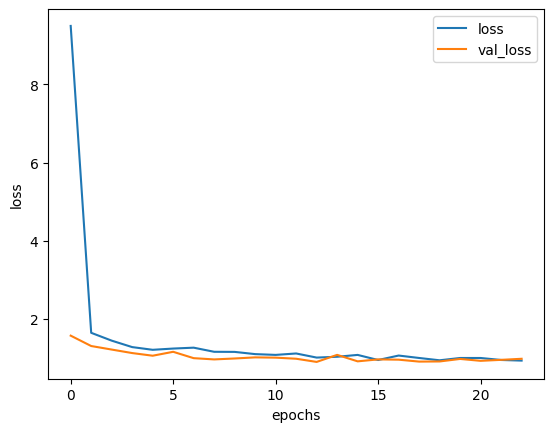

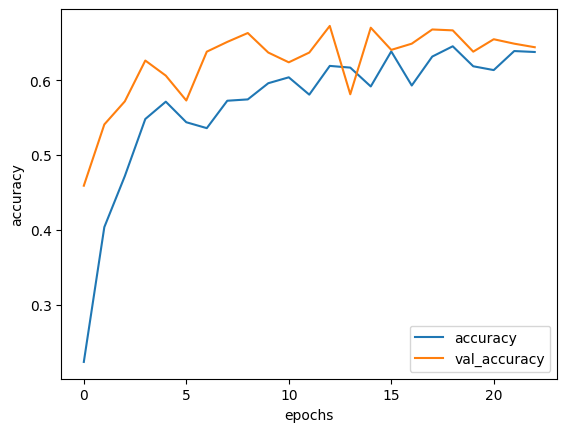

In [265]:
df = pd.DataFrame(history_base.history)
df.plot(y=['loss', 'val_loss'], xlabel='epochs', ylabel='loss')

df = pd.DataFrame(history_base.history)
df.plot(y=['accuracy', 'val_accuracy'], xlabel='epochs', ylabel='accuracy')

### Deploy del modelo

In [266]:
model_base.save('./model_base.h5')

In [267]:
X_test= preprocessig_data(X_test)
y_test = le.transform(y_test)
y_test = to_categorical(y_test)

In [268]:
y_pred_base = model_base.predict(X_test)
y_pred_base = y_pred_base.argmax(axis=-1)

print('Ejemplo predicción: ', y_pred_base[0])
print('Ejemplo valor real: ', y_test[0].argmax(axis=-1))

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Ejemplo predicción:  6
Ejemplo valor real:  6


### Reporte resultado

In [269]:
score = model_base.evaluate(X_test, y_test, verbose=1)
print(f'Test loss: {score[0]}\nTest Accuracy: {score[1]}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6595 - loss: 1.0197
Test loss: 1.0452443361282349
Test Accuracy: 0.6377671957015991


In [270]:
Y_test = y_test.argmax(axis=-1)

print('Reporte para el modelo sin convolucion'.center(60,'-'))
print(classification_report(Y_test, y_pred_base, target_names=['fruit', 'person', 'car', 'cat', 'flower', 'motorbike', 'airplane', 'dog']))

-----------Reporte para el modelo sin convolucion-----------
              precision    recall  f1-score   support

       fruit       0.69      0.74      0.72       116
      person       0.76      0.68      0.72       101
         car       0.37      0.39      0.38       111
         cat       0.55      0.34      0.42       112
      flower       0.40      0.61      0.48       115
   motorbike       0.92      0.74      0.82        97
    airplane       0.85      0.79      0.82       105
         dog       0.84      0.89      0.86        85

    accuracy                           0.64       842
   macro avg       0.67      0.65      0.65       842
weighted avg       0.66      0.64      0.64       842



## Punto 2: Clasificación de imágenes con ConvNets

Requerimientos básicos:
- Contruir una red convolucional de al menos 3 capas convolucionales. Utilice las mismas particiones del punto 1.
- Guardar el modelo proveniente de la red convolucional.
- Hacer deploy del modelo (realizar prediccion sobre una imagen dada).
- De ser necesario realizar estrategias de aumentación de datos

## Punto 3: Comparación

Compare los modelos, cual se comporto mejor?, por qué?

In [271]:
model_base_report = classification_report(Y_test, y_pred_base, target_names=['fruit', 'person', 'car', 'cat', 'flower', 'motorbike', 'airplane', 'dog'], output_dict=True)

data = {
    'Model': ['Modelo sin convolución', 'Modelo con convolución'],
    'Accuracy': [
      model_base_report['macro avg']['precision'],
      0,
    ],
    'Recall': [
      model_base_report['macro avg']['recall'],
      0
    ],
    'F1 Score': [
      model_base_report['macro avg']['f1-score'],
      0
    ]
}
df = pd.DataFrame(data)
df.set_index('Model', inplace=True)
df.sort_values(by=['F1 Score'],ascending=False)

Accuracy    Recall  F1 Score
Model                                               
Modelo sin convolución  0.672298  0.648347  0.652643
Modelo con convolución  0.000000  0.000000  0.000000